# Visibilities
---

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import torch
import k3d

from p3droslo.observation import DataCube
from p3droslo.utils       import convert_angular_to_spatial
from p3droslo.object      import AstroObject
from scipy.spatial        import KDTree
from astropy              import constants, units

In [2]:
dat = DataCube('/STER/frederikd/Deprojection/data/observations/IKTau_NaCl26-25.fits')

In [3]:
# Extract object data from Simbad
obj = AstroObject('IK Tau')

Using the parallax distance.


In [4]:
dat.plot_channel_maps()

interactive(children=(IntSlider(value=37, description='f', max=75), Output()), _dom_classes=('widget-interact'…

<function p3droslo.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

## Interpolation
---

In [5]:
N = 5
M = 4

x = np.linspace(0, N, N)
y = np.linspace(0, M, M)

X, Y = np.meshgrid(x,y)

Z = np.sqrt(X**2+Y**2)

# spline = RectBivariateSpline(y, x, Z, kx=1, ky=1, s=0)

In [6]:
XX, YY = np.meshgrid(
    np.linspace(0, N, 100*N),
    np.linspace(0, M, 100*M)
)

In [7]:
from scipy.spatial import KDTree


class Lagrange1Interpolation:
    """
    Lagrange interpolation with the 1 nearest point.
    """

    def __init__(self, eval_points, data_points):
        """
        Constructor for Lagrange interpolation object.
        (With the Lagrange interpolation polynomials in terms of distances.)
        """
        # Store evaluation and data points
        self.eval_points = eval_points
        self.data_points = data_points

        # Get the 3 nearest neighbouring data points for each eval point
        dist, index = KDTree(self.data_points).query(self.eval_points, k=1)

        # Extract distances to and indices of the 3 nearest neighbours
        self.d0 = dist.T
        self.i0 = index.T

        # Cast to Torch Tensors
        self.i0_torch = torch.from_numpy(self.i0)

    def eval(self, y):
        """
        Evaluate interpolant for the given data.
        """
        # Return interpolation
        return   y[self.i0]
    
    def eval_torch(self, y):
        """
        Evaluate interpolant for the given data.
        """
        # Return interpolation
        return   y[self.i0_torch]


class Lagrange3Interpolation:
    """
    Lagrange interpolation with the 3 nearest points.
    """

    def __init__(self, eval_points, data_points):
        """
        Constructor for Lagrange interpolation object.
        (With the Lagrange interpolation polynomials in terms of distances.)
        """
        # Store evaluation and data points
        self.eval_points = eval_points
        self.data_points = data_points

        # Get the 3 nearest neighbouring data points for each eval point
        dist, index = KDTree(self.data_points).query(self.eval_points, k=3)

        # Extract distances to and indices of the 3 nearest neighbours
        self.d0, self.d1, self.d2 = dist.T
        self.i0, self.i1, self.i2 = index.T

        # Compute inverse of distances between the neighbours
        id01 = 1.0 / np.linalg.norm(self.data_points[self.i0] - self.data_points[self.i1], axis=1)
        id12 = 1.0 / np.linalg.norm(self.data_points[self.i1] - self.data_points[self.i2], axis=1)
        id02 = 1.0 / np.linalg.norm(self.data_points[self.i0] - self.data_points[self.i2], axis=1)

        # Compute the evaluations of the Lagrange polynomials
        self.fac0 = self.d1 * self.d2 * id01 * id02
        self.fac1 = self.d0 * self.d2 * id01 * id12
        self.fac2 = self.d0 * self.d1 * id02 * id12

        # Cast to Torch Tensors
        self.fac0_torch = torch.from_numpy(self.fac0)
        self.fac1_torch = torch.from_numpy(self.fac1)
        self.fac2_torch = torch.from_numpy(self.fac2)

        # Cast to Torch Tensors
        self.i0_torch = torch.from_numpy(self.i0)
        self.i1_torch = torch.from_numpy(self.i1)
        self.i2_torch = torch.from_numpy(self.i2)


    def eval(self, y):
        """
        Evaluate interpolant for the given data.
        """
        # Return interpolation
        return   self.fac0 * y[self.i0] \
               + self.fac1 * y[self.i1] \
               + self.fac2 * y[self.i2]
    
    def eval_torch(self, y):
        """
        Evaluate interpolant for the given data.
        """
        # Return interpolation
        return   self.fac0_torch * y[self.i0_torch] \
               + self.fac1_torch * y[self.i1_torch] \
               + self.fac2_torch * y[self.i2_torch]
               

class Lagrange4Interpolation:
    """
    Lagrange interpolation with the 4 nearest points.
    """

    def __init__(self, eval_points, data_points):
        """
        Constructor for Lagrange interpolation object.
        (With the Lagrange interpolation polynomials in terms of distances.)
        """
        # Store evaluation and data points
        self.eval_points = eval_points
        self.data_points = data_points

        # Get the 3 nearest neighbouring data points for each eval point
        dist, index = KDTree(self.data_points).query(self.eval_points, k=4)

        # Extract distances to and indices of the 3 nearest neighbours
        self.d0, self.d1, self.d2, self.d3 = dist.T
        self.i0, self.i1, self.i2, self.i3 = index.T

        # Compute inverse of distances between the neighbours
        id01 = 1.0 / np.linalg.norm(self.data_points[self.i0] - self.data_points[self.i1], axis=1)
        id12 = 1.0 / np.linalg.norm(self.data_points[self.i1] - self.data_points[self.i2], axis=1)
        id02 = 1.0 / np.linalg.norm(self.data_points[self.i0] - self.data_points[self.i2], axis=1)
        id03 = 1.0 / np.linalg.norm(self.data_points[self.i0] - self.data_points[self.i3], axis=1)
        id13 = 1.0 / np.linalg.norm(self.data_points[self.i1] - self.data_points[self.i3], axis=1)
        id23 = 1.0 / np.linalg.norm(self.data_points[self.i2] - self.data_points[self.i3], axis=1)

        # Compute the evaluations of the Lagrange polynomials
        self.fac0 = self.d1 * self.d2 * self.d3 * id01 * id02 * id03
        self.fac1 = self.d0 * self.d2 * self.d3 * id01 * id12 * id13
        self.fac2 = self.d0 * self.d1 * self.d3 * id02 * id12 * id23
        self.fac3 = self.d0 * self.d1 * self.d2 * id03 * id13 * id23

        # Cast to Torch Tensors
        self.fac0_torch = torch.from_numpy(self.fac0)
        self.fac1_torch = torch.from_numpy(self.fac1)
        self.fac2_torch = torch.from_numpy(self.fac2)
        self.fac3_torch = torch.from_numpy(self.fac3)

        # Cast to Torch Tensors
        self.i0_torch = torch.from_numpy(self.i0)
        self.i1_torch = torch.from_numpy(self.i1)
        self.i2_torch = torch.from_numpy(self.i2)
        self.i3_torch = torch.from_numpy(self.i3)


    def eval(self, y):
        """
        Evaluate interpolant for the given data.
        """
        # Return interpolation
        return   self.fac0 * y[self.i0] \
               + self.fac1 * y[self.i1] \
               + self.fac2 * y[self.i2] \
               + self.fac3 * y[self.i3]  
    
    def eval_torch(self, y):
        """
        Evaluate interpolant for the given data.
        """
        # Return interpolation
        return   self.fac0_torch * y[self.i0_torch] \
               + self.fac1_torch * y[self.i1_torch] \
               + self.fac2_torch * y[self.i2_torch] \
               + self.fac3_torch * y[self.i3_torch]

In [8]:
interpolate1 = Lagrange1Interpolation(
    data_points = np.stack((X.ravel(), Y.ravel())).T,
    eval_points = np.stack((XX.ravel(), YY.ravel())).T
)

interpolate3 = Lagrange3Interpolation(
    data_points = np.stack((X.ravel(), Y.ravel())).T,
    eval_points = np.stack((XX.ravel(), YY.ravel())).T
)

interpolate4 = Lagrange4Interpolation(
    data_points = np.stack((X.ravel(), Y.ravel())).T,
    eval_points = np.stack((XX.ravel(), YY.ravel())).T
)

In [9]:
res1 = interpolate1.eval(Z.ravel()).reshape((XX.shape[0], XX.shape[1]))
res3 = interpolate3.eval(Z.ravel()).reshape((XX.shape[0], XX.shape[1]))
res4 = interpolate4.eval(Z.ravel()).reshape((XX.shape[0], XX.shape[1]))

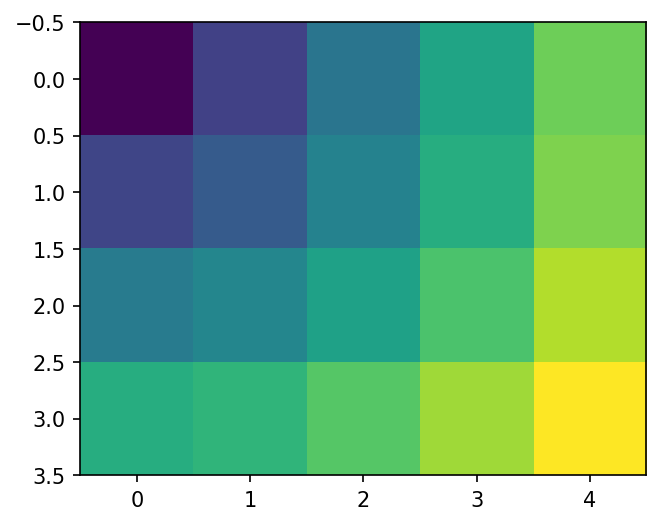

In [10]:
plt.figure(dpi=150)
plt.imshow(Z)

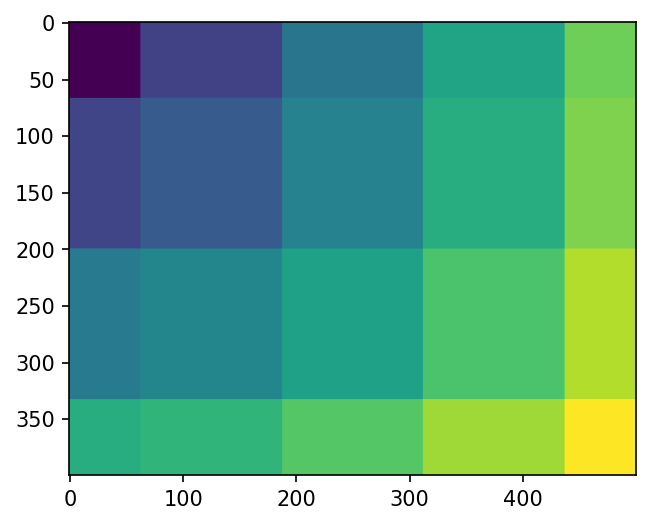

In [11]:
plt.figure(dpi=150)
plt.imshow(res1)

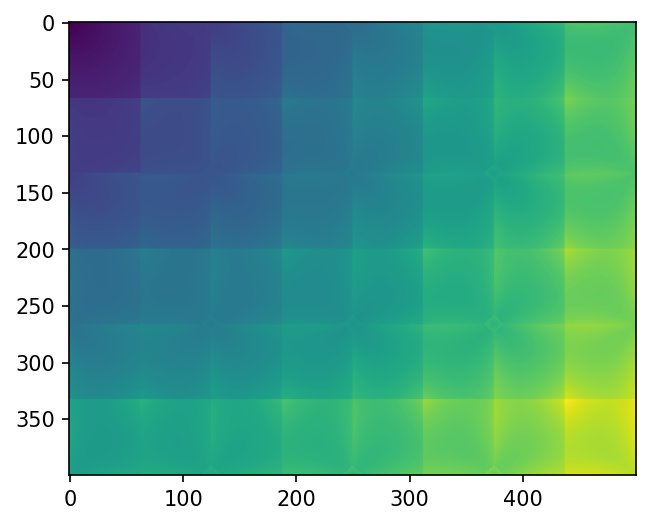

In [12]:
plt.figure(dpi=150)
plt.imshow(res3)

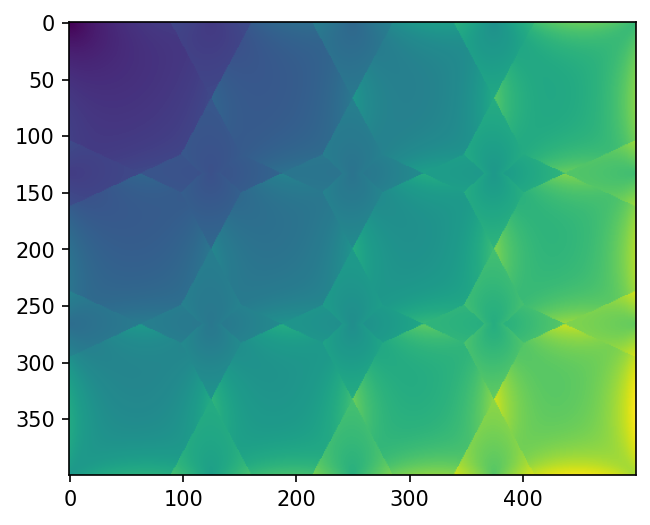

In [13]:
plt.figure(dpi=150)
plt.imshow(res4)

## Extracting visibilities form calibrated measuremnt set
---

In [14]:
# Path to the measurement set
ms_file = '/STER/frederikd/Data/IK_Tau/uid___A002_Xa7f9e3_X3c9.ms.split.cal'
# ms_file = '/STER/frederikd/Data/IK_Tau/uid___A002_Xa7f9e3_X797.ms.split.cal'
# ms_file = '/STER/frederikd/Data/IK_Tau/uid___A002_Xa80456_X2fdc.ms.split.cal'
# ms_file = '/STER/frederikd/Data/IK_Tau/uid___A002_Xa901a7_X2bcd.ms.split.cal'

f_min = dat.f_min.si.value
f_max = dat.f_max.si.value

output_file = 'visibilities.npz' 

In [15]:
# Reference https://casa.nrao.edu/casadocs/casa-5.3.0/reference-material/measurement-set
from casacore.tables import table

# Open the measurement set
ms = table(ms_file, readonly=True)

# Get the SPECTRAL_WINDOW table
spw_table = table(ms.getkeyword("SPECTRAL_WINDOW"), readonly=True)

# Initialize lists for channel information
data_desc_ids = []
chan_freqs    = []
chan_widths   = []
chan_masks    = []

# Get the frequency information
for spw_id in range(spw_table.nrows()):
    # Center frequencies for each channel in the data matrix.
    chan_freq = spw_table.getcell("CHAN_FREQ",  spw_id)
    # Channel width for each channel in the data matrix.
    chan_width = spw_table.getcell("CHAN_WIDTH", spw_id)
    # Get lower and upper bounds for each frequency channel
    chan_lower = chan_freq - 0.5 * np.abs(chan_width)
    chan_upper = chan_freq + 0.5 * np.abs(chan_width)
    # Mask for the relevant frequency channels
    chan_mask = np.logical_and(chan_upper >= f_min, chan_lower <= f_max)
    # If there are relevant frequency channels in this spectral window, append
    if chan_mask.sum() > 0:
        data_desc_ids.append(spw_id    )
        chan_freqs   .append(chan_freq )
        chan_widths  .append(chan_width)
        chan_masks   .append(chan_mask )

# Close the SPECTRAL_WINDOW table
spw_table.close()

for data_desc_id, chan_freq, chan_width, chan_mask in zip(data_desc_ids, chan_freqs, chan_widths, chan_masks):
    
    # Filter out the relevant part of the measurement set
    ms_filtered = ms.query(f"DATA_DESC_ID == {data_desc_id}")
    # Extract the UVW baseline coordinates [m]
    # https://casa.nrao.edu/casadocs/casa-5.3.0/reference-material/measurement-set
    u, v, w = ms_filtered.getcol("UVW").T

    # ??? Project by only considering the u and v component ???
    
    # Extract the weights
    weight = ms_filtered.getcol("WEIGHT")
    # Extract the visibilities
    data = ms_filtered.getcol('DATA')
    # Close the filtered measurement set
    ms_filtered.close()
    # Filter out the relevant frequency channels
    data           = data[:, chan_mask, :]
    channel_freqs  = chan_freq [chan_mask]
    channel_widths = chan_width[chan_mask]
    # Add the two polarizations weights
    weight_tot = weight[:, 0] + weight[:, 1]
    # Compute the weighted average of the polarized visibilities
    POL_XX = np.einsum("i, if -> if", weight[:, 0] / weight_tot, data[:, :, 0])
    POL_YY = np.einsum("i, if -> if", weight[:, 1] / weight_tot, data[:, :, 1])
    visibilities = POL_XX + POL_YY
    # Store the extracted data 
    np.savez(
        file           = output_file,
        u              = u,
        v              = v,
        w              = w,
        visibilities   = visibilities,
        channel_freqs  = channel_freqs,
        channel_widths = channel_widths,
        weight         = weight_tot
    )

# Close the measurement set
ms.close()

Successful readonly open of default-locked table /STER/frederikd/Data/IK_Tau/uid___A002_Xa7f9e3_X3c9.ms.split.cal: 23 columns, 803600 rows
Successful readonly open of default-locked table /STER/frederikd/Data/IK_Tau/uid___A002_Xa7f9e3_X3c9.ms.split.cal/SPECTRAL_WINDOW: 17 columns, 4 rows


In [16]:
data = np.load("visibilities.npz")
u              = data['u'] # [m]
v              = data['v'] # [m]
w              = data['w'] # [m]
visibilities   = data['visibilities']
channel_freqs  = data['channel_freqs']
channel_widths = data['channel_widths']
weight         = data['weight']

In [17]:
channel_wavelengths = constants.c.si.value / channel_freqs 

In [18]:
import k3d

plt_points = k3d.points(
    positions  = np.stack([u,v,w]).astype(np.float32).T,
    point_size = 1,
    shader     = '3d'
)

plot = k3d.plot()
plot += plt_points
plot.display()

Output()

## Simulate visibilities
---

In [56]:
channel = 43

assert(dat.npix_x == dat.npix_y)
assert(abs(dat.pixsize_x) == abs(dat.pixsize_y))

nxy = dat.npix_x
# dxy = abs(convert_angular_to_spatial(dat.pixsize_x, obj.distance)).si.value
dxy = abs(dat.pixsize_x.si.value)

# Grid size in uv space
du = 1.0 / (nxy * dxy)

u_axs = torch.linspace(0.0, nxy//2, nxy//2+1)
v_axs = torch.linspace(0.0, nxy-1, nxy)

# Mask where u is negetive
uneg = u < 0.0

# Make u and v unitless by dividing by wavelength
u /= channel_wavelengths[channel]
v /= channel_wavelengths[channel]

# Compute interpolation indices
# note t
u_idx       = np.abs(u)         / du
v_idx       = 0.5*nxy + v       / du
v_idx[uneg] = 0.5*nxy - v[uneg] / du

# Create grid of indices
U_axs, V_axs = np.meshgrid(u_axs, v_axs)

In [64]:
interpolate4 = Lagrange4Interpolation(
    data_points = np.stack((U_axs.ravel(), V_axs.ravel())).T,
    eval_points = np.stack((u_idx,         v_idx        )).T
)

In [65]:
fft_img2 = dat.img[43]
fft_img2 = np.fft.fftshift(fft_img2)
fft_img2 = np.fft.rfft2   (fft_img2)
fft_img2 = np.fft.fftshift(fft_img2, axes=0)

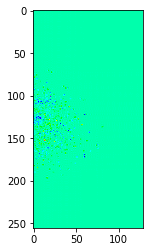

In [66]:
plt.imshow(fft_img2.real, cmap='gist_rainbow')

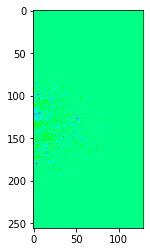

In [67]:
plt.imshow(fft_img2.imag, cmap='gist_rainbow')

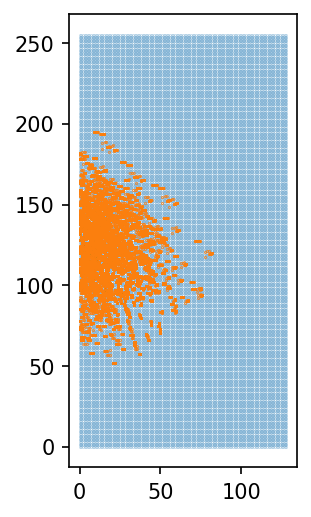

In [88]:
fig, axs = plt.subplots(1,1, dpi=150)
axs.scatter(U_axs.ravel(), V_axs.ravel(), s=0.01)
axs.scatter(u_idx, v_idx, s=0.01)
axs.set_aspect('equal')

In [81]:
interpolate4.eval(fft_img2.ravel())

array([-0.96090203+0.j        , -0.96090203+0.j        ,
       -0.96090203+0.j        , ...,  0.00753123-0.41119025j,
       -0.33326294+0.03681047j,  1.92295733-1.56059013j])

In [80]:
visibilities[:,channel]

array([12.136303  +0.j        , 14.142774  +0.j        ,
       14.107454  +0.j        , ...,  1.0503724 -0.30173498j,
        0.04100361+0.24492508j,  0.91197735+0.02072871j], dtype=complex64)

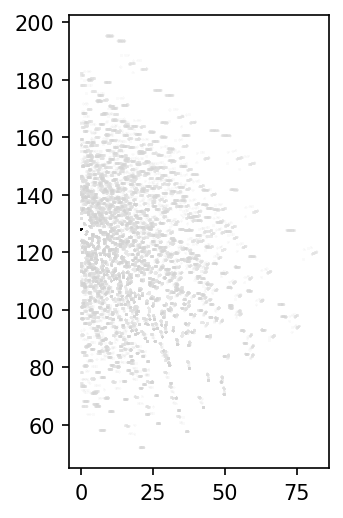

In [93]:
fig, axs = plt.subplots(1,1, dpi=150)
axs.scatter(u_idx, v_idx, c=visibilities[:,channel].real, s=0.01, cmap='Greys', alpha=0.1)
axs.set_aspect('equal')

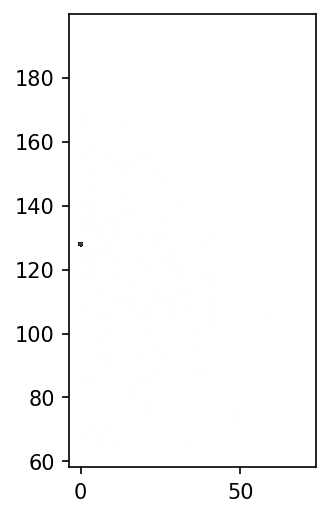

In [112]:
vis_r = visibilities[:,channel].real
threshold = np.sort(vis_r)[-10000]
mask = vis_r > threshold

fig, axs = plt.subplots(1,1, dpi=150)
axs.scatter(u_idx[mask], v_idx[mask], c=vis_r[mask], s=1, cmap='Greys', alpha=0.1)
axs.set_aspect('equal')

In [98]:
vis_r

array([12.136303  , 14.142774  , 14.107454  , ...,  1.0503724 ,
        0.04100361,  0.91197735], dtype=float32)

14.476116

In [ ]:
fft_img = torch.from_numpy(dat.img[43])
fft_img = torch.fft.fftshift(fft_img)
fft_img = torch.fft.rfft2   (fft_img)
fft_img = torch.fft.fftshift(fft_img, dim=0)

In [ ]:
fft_img = torch.from_numpy(dat.img)
fft_img = torch.fft.fftshift(fft_img)
fft_img = torch.fft.rfft2   (fft_img)
fft_img = torch.fft.fftshift(fft_img, dim=0)

In [ ]:
dat.img.shape

(76, 256, 256)

In [ ]:
fft_img.shape

torch.Size([76, 256, 129])

In [ ]:
np.abs((fft_img.data - fft_img2) / (fft_img.data + fft_img2)).max()

tensor(1246.3974, dtype=torch.float64)

TypeError: Invalid shape (76, 256, 129) for image data

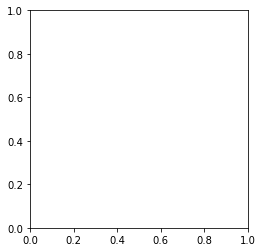

In [ ]:
plt.imshow(fft_img.data.real)